In [73]:
# =========================================
# Clasificación breast_cancer.csv con Regresión Logística + RandomizedSearchCV
# =========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Regla de estilo para plots
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.utils.class_weight import compute_class_weight
from math import sqrt
import joblib
from scipy.stats import uniform



In [74]:
datos = pd.read_csv(filepath_or_buffer="C:/Users/jenif/Downloads/breast-cancer.csv")

In [75]:
datos

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [76]:
# -----------------------------------------
# 2) Configurar TARGET y limpieza mínima
# -----------------------------------------
TARGET_COLUMN = "diagnosis"  # Columna objetivo

# Convertir etiquetas M/B a 1/0
y = datos[TARGET_COLUMN].map({"M": 1, "B": 0})

# Eliminar la columna objetivo y columnas no informativas
X = datos.drop(columns=[TARGET_COLUMN, "id"], errors="ignore")

print("Dimensiones de X:", X.shape)
print("Balance de clases:")
print(y.value_counts(normalize=True).rename("proporcion"))


Dimensiones de X: (569, 30)
Balance de clases:
diagnosis
0    0.627417
1    0.372583
Name: proporcion, dtype: float64


In [77]:
# Columnas numéricas y categóricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [78]:
# 3) Preprocesamiento
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe())
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
])


In [79]:
# 4) Modelo
base_clf = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    solver="saga"
)

pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", base_clf)
])


In [80]:
# 5) Espacio de búsqueda
param_distributions = [
    # Caso L1 con liblinear
    {
        "clf__penalty": ["l1"],
        "clf__solver": ["liblinear", "saga"],
        "clf__C": uniform(0.01, 10)
    },
    # Caso L2 con ambos solvers
    {
        "clf__penalty": ["l2"],
        "clf__solver": ["liblinear", "saga", "lbfgs", "newton-cg", "sag"],
        "clf__C": uniform(0.01, 10)
    },
    # Caso elasticnet solo con saga
    {
        "clf__penalty": ["elasticnet"],
        "clf__solver": ["saga"],
        "clf__C": uniform(0.01, 10),
        "clf__l1_ratio": uniform(0, 1)
    }
]


In [81]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=40,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)


In [82]:
# 6) Train/test split y ajuste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rs.fit(X_train, y_train)
print("\nMejor AUC-ROC (CV):", rs.best_score_)
print("Mejores hiperparámetros:", rs.best_params_)

best_model = rs.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits

Mejor AUC-ROC (CV): 0.9954592363261094
Mejores hiperparámetros: {'clf__C': np.float64(0.4766566321361543), 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}


In [83]:
# 7) Evaluación en test
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== Métricas en Test ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1       : {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_proba):.4f}")


=== Métricas en Test ===
Accuracy : 0.9825
Precision: 0.9762
Recall   : 0.9762
F1       : 0.9762
ROC-AUC  : 0.9970


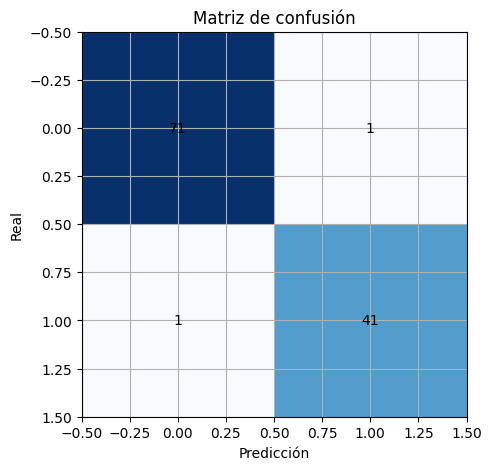

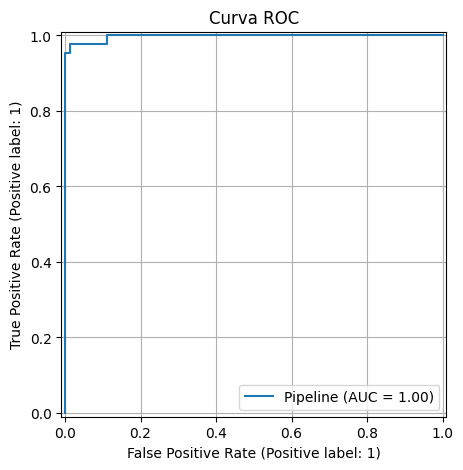

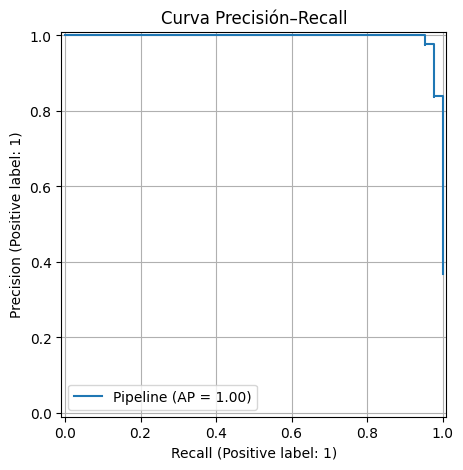

In [84]:

# 8) Gráficas
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Matriz de confusión")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Curva ROC")
plt.show()

PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Curva Precisión–Recall")
plt.show()


In [85]:
# 9) Guardar modelo
os.makedirs("model", exist_ok=True)
model_path = os.path.join("model", "logreg_breast_cancer.pkl")
joblib.dump(best_model, model_path)
print(f"\nModelo guardado en: {model_path}")


Modelo guardado en: model\logreg_breast_cancer.pkl
